## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
from competitions import dogscats;

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
TRAIN_PATH = cfg.PATHS['datasets']['inputs']['trn_jpg'] 
TEST_PATH = cfg.PATHS['datasets']['inputs']['tst_jpg'] 
LABEL_AI_METADATA_PATH = os.path.join(cfg.PATHS['project'], 'labelai.csv')
metadata_df = metadata.get_metadata_df(
    cfg.METADATA_PATH)

In [20]:
HARDWARE_CONFIG = {
    'hostname': socket.gethostname(),
    'random_seed': 3,
    'gpu_device':0
}
torch.cuda.set_device(HARDWARE_CONFIG['gpu_device'])
cudnn.benchmark = True

DATA_CONFIG = {
    'img_rescale': 256,
    'dset_fold': 'labelai',
    'n_classes': len(dogscats.LABEL_NAMES)
}

TRAIN_CONFIG = {
    'initial_lr': 1e-4,
    'weight_decay': 1e-4,
    'n_epochs': 100,
    'n_cycles': 9,
    'early_stop_metric': metric.Loss().name,
    'max_patience': 20,
    'batch_size': 16,
    'threshold': 0.5,
    'save_weights_cadence': 1, #every epoch
    'lr_schedule': {50:1e-4}
}
OTHER_CONFIG = {}

TRANSFORMS = {
    c.TRAIN: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         torchsample.transforms.RandomShear(-.1),
#         torchsample.transforms.RandomZoom((.9,1.1)),
        data_aug.IMAGENET_NORMALIZE
    ]),
    c.VAL: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        transforms.ToTensor(),
        data_aug.IMAGENET_NORMALIZE
    ]),
    c.TEST: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        transforms.ToTensor(),
        data_aug.IMAGENET_NORMALIZE
    ])
}

## Data

In [4]:
# Make new fold (if not exists)
fpaths,fnames = utils.files.get_paths_to_files(TRAIN_PATH)
val_size = math.floor(len(fnames)*.2)
fold = data_folds.make_fold(DATA_CONFIG['dset_fold'], TRAIN_PATH, TEST_PATH, 
                             cfg.PATHS['folds'], val_size, shuffle=False)
print("total", len(fpaths), "val",len(fold['val']), 'trn',len(fold['trn']))

total 25000 val 5000 trn 20000


In [5]:
SAMPLE = 1000000
fold = data_folds.load_data_fold(cfg.PATHS['folds'], DATA_CONFIG['dset_fold'])
trn_fpaths = data_folds.get_fpaths_from_fold(fold, c.TRAIN, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)[:SAMPLE]
val_fpaths = data_folds.get_fpaths_from_fold(fold, c.VAL, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)
tst_fpaths = data_folds.get_fpaths_from_fold(fold, c.TEST, TEST_PATH, postfix=c.JPG_EXT)

In [6]:
def init_dataset(input_dir, fold_fpath, file_ext, label_names=None):
    fpaths, ids = utils.files.get_paths_to_files(input_dir, strip_ext=True)
    label_names = [] if label_names is None else label_names
    fold = {
        'file_ext': file_ext,
        'inputs_dir': input_dir,
        'label_names': sorted(label_names),
        'trn': {},
        'val': {},
        'tst': {}, #auditing purposes
        'unlabeled': {} #these need to be queried and popped by key
    }
    for id_ in ids:
        fold['unlabeled'][id_] = id_
    utils.files.save_json(fold_fpath, fold)
    return fold

def make_entry(labels=None, model_labels=None, model_probs=None):
    labels = [] if labels is None else labels
    model_labels = [] if model_labels is None else model_labels
    model_probs = [] if model_probs is None else model_probs
    return {
        'labels': labels,
        'model_labels': model_labels,
        'model_probs': model_probs,
    }

def add_or_update_entry(fold, dset, id_, entry):
    fold[dset][id_] = entry

def move_unlabeled_to_labeled(fold, dset, id_, entry):
    del fold['unlabeled'][id_]
    add_or_update_entry(fold, dset, id_, entry)

In [7]:
labels = ['cat', 'dog']
label_fold_fpath = os.path.join(cfg.PROJECT_PATH, 'labelai.json')

In [8]:
##label_fold = init_dataset(cfg.PATHS['datasets']['inputs']['trn_jpg'], label_fold_fpath, c.JPG_EXT, labels)

In [9]:
label_fold = utils.files.load_json(label_fold_fpath)
print(label_fold.keys())
label_fold['trn'],label_fold['val'], label_fold['tst'], len(label_fold['unlabeled'].keys())

dict_keys(['file_ext', 'inputs_dir', 'label_names', 'trn', 'val', 'tst', 'unlabeled'])


({'cat.328': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.3326': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.3523': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.3660': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.3672': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.3748': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.3772': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.3834': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.3844': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.3943': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.412': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.4139': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.4170': {'labels': ['cat'], 'model_labels': [], 'model_probs': []},
  'cat.4230': {'labels': ['cat'], 'model

In [10]:
len(label_fold['unlabeled'].keys())

20000

In [21]:
# Refresh Dataset
labels = ['cat', 'dog']
label_fold_fpath = os.path.join(cfg.PROJECT_PATH, 'labelai.json')
label_fold = utils.files.load_json(label_fold_fpath)
print(label_fold.keys())
trn_fpaths, trn_targs = metadata.get_fpaths_targs_from_label_fold(label_fold, c.TRAIN)
val_fpaths, val_targs = metadata.get_fpaths_targs_from_label_fold(label_fold, c.VAL)
tst_fpaths, tst_targs = metadata.get_fpaths_targs_from_label_fold(label_fold, c.TEST)
print(len(trn_fpaths), trn_targs.shape, len(val_fpaths), val_targs.shape, len(tst_fpaths), tst_targs.shape)
img_reader = 'pil'
trn_dataset = datasets.datasets.FileDataset(
    trn_fpaths, img_reader, trn_targs, TRANSFORMS[c.TRAIN])
val_dataset = datasets.datasets.FileDataset(
    val_fpaths, img_reader, val_targs, TRANSFORMS[c.VAL])
tst_dataset = datasets.datasets.FileDataset(
    tst_fpaths, img_reader, tst_targs, TRANSFORMS[c.TEST])
print("trn",len(trn_dataset),"val",len(val_dataset),"tst",len(tst_dataset))

trn_loader = data_loaders.get_data_loader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                          shuffle=True, n_workers=4, pin_memory=True)
val_loader = data_loaders.get_data_loader(val_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=2, pin_memory=True)
tst_loader = data_loaders.get_data_loader(tst_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=2, pin_memory=True)

dict_keys(['file_ext', 'inputs_dir', 'label_names', 'trn', 'val', 'tst', 'unlabeled'])
254 (254, 2) 67 (67, 2) 5000 (5000, 2)
trn 254 val 67 tst 5000


In [22]:
# tst_ids = list(label_fold['unlabeled'].keys())[:5000]
# print(len(tst_ids))
# for id_ in tst_ids:
#     labels = metadata.get_tags_by_id(metadata_df, id_)
#     entry = make_entry(labels)
#     move_unlabeled_to_labeled(label_fold, 'tst', id_, entry)
# label_fold['trn'],label_fold['val'], len(label_fold['tst'].keys()), len(label_fold['unlabeled'].keys())

In [23]:
trn_fpaths, trn_targs = metadata.get_fpaths_targs_from_label_fold(label_fold, c.TRAIN)
val_fpaths, val_targs = metadata.get_fpaths_targs_from_label_fold(label_fold, c.VAL)
tst_fpaths, tst_targs = metadata.get_fpaths_targs_from_label_fold(label_fold, c.TEST)

In [14]:
utils.files.save_json(label_fold_fpath, label_fold)

In [24]:
print(len(trn_fpaths), trn_targs.shape, len(val_fpaths), val_targs.shape, len(tst_fpaths), tst_targs.shape)

254 (254, 2) 67 (67, 2) 5000 (5000, 2)


In [25]:
img_reader = 'pil'
trn_dataset = datasets.datasets.FileDataset(
    trn_fpaths, img_reader, trn_targs, TRANSFORMS[c.TRAIN])
val_dataset = datasets.datasets.FileDataset(
    val_fpaths, img_reader, val_targs, TRANSFORMS[c.VAL])
tst_dataset = datasets.datasets.FileDataset(
    tst_fpaths, img_reader, tst_targs, TRANSFORMS[c.TEST])
print("trn",len(trn_dataset),"val",len(val_dataset),"tst",len(tst_dataset))

trn_loader = data_loaders.get_data_loader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                          shuffle=True, n_workers=4, pin_memory=True)
val_loader = data_loaders.get_data_loader(val_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=2, pin_memory=True)
tst_loader = data_loaders.get_data_loader(tst_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=2, pin_memory=True)

trn 254 val 67 tst 5000


In [26]:
inputs,targets,img_paths = next(iter(tst_loader))
inputs.size(),targets.size(),img_paths[:3]

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 2]),
 ['/bigguy/data/dogscats/datasets/inputs/trn_jpg/cat.0.jpg',
  '/bigguy/data/dogscats/datasets/inputs/trn_jpg/cat.1.jpg',
  '/bigguy/data/dogscats/datasets/inputs/trn_jpg/cat.10.jpg'])

## Train

In [18]:
resnet = models.resnet.get_resnet34(pretrained=True, n_freeze=99999, verbose=False)
resnet = models.builder.cut_model(resnet, -1)
classifier = models.builder.get_classifier(in_feat=512, n_classes=len(label_fold['label_names']),
                                           activation=nn.Softmax(), p=0.5)
model = models.resnet.SimpleResnet(resnet, classifier)
model = model.cuda()
# outputs = model(Variable(inputs))
# print(outputs.size(), targets.size())

In [ ]:
# Load existing weights (optional)
experiment_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd1e-05-bs32-fold5K-id767AD'
epoch = 30
exp_utils.load_weights_by_exp_and_epoch(model, experiment_name, epoch)

In [27]:
# Initialize trainer
criterion = F.binary_cross_entropy
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       TRAIN_CONFIG['initial_lr'], weight_decay=TRAIN_CONFIG['weight_decay'])
lr_adjuster = learning_rates.ScheduledLR(TRAIN_CONFIG['initial_lr'], 'epoch', 
                                         TRAIN_CONFIG['lr_schedule'])
trainer = trainers.Trainer(criterion, criterion, optimizer, lr_adjuster)

In [28]:
# Experiment config
NEW_EXP_NAME = 'LabelAI'
RESUME_EXP_NAME = None #'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
if not RESUME_EXP_NAME:
    EXP_NAME_ARGS = [utils.general.get_class_name(model), 
                    utils.general.get_class_name(optimizer), 
                    utils.general.get_class_name(lr_adjuster),
                    'img'+str(DATA_CONFIG['img_rescale']),
                    'lr'+str(TRAIN_CONFIG['initial_lr']),
                    'wd'+str(TRAIN_CONFIG['weight_decay']),
                    'bs'+str(TRAIN_CONFIG['batch_size']),
                    str(DATA_CONFIG['dset_fold'])]
    EXPERIMENT_NAME = exp_utils.generate_display_name(NEW_EXP_NAME, EXP_NAME_ARGS)
    METRICS = [metric.Loss(), metric.Accuracy(), metric.F2Score()]
    AUX_METRICS = [metric.AuxiliaryMetric('LearningRate', 'lr'), 
                   metric.AuxiliaryMetric('SystemMemory', 'mb')]
    VISUALIZERS = [Viz(EXPERIMENT_NAME)]

    EXP_CONFIG = {
        'name': EXPERIMENT_NAME,
        'parent_dir': cfg.PATHS['experiments'],
        'metrics': METRICS,
        'aux_metrics': AUX_METRICS,
        'visualizers': VISUALIZERS,
        'data': DATA_CONFIG,
        'training': TRAIN_CONFIG,
        'other': OTHER_CONFIG,
        'transforms': TRANSFORMS[c.TRAIN],
        'hardware': HARDWARE_CONFIG,
        'model': model,
        'optimizer': optimizer,
        'lr_adjuster': lr_adjuster,
        'criterion': criterion
    }

In [ ]:
# Resume experiment
exp = Experiment(RESUME_EXP_NAME, cfg.PATHS['experiments'])
exp.resume(verbose=True)
trainer = trainers.Trainer(criterion, criterion, exp.optim, lr_adjuster)

In [29]:
# Create new experiment
exp = Experiment(EXP_CONFIG['name'], cfg.PATHS['experiments'])
exp.init(EXP_CONFIG)
print(exp.name)

LabelAISimpleResnet-Adam-ScheduledLR-img256-lr0.0001-wd0.0001-bs16-labelai-id518F9


In [30]:
# Refresh Dataset
labels = ['cat', 'dog']
label_fold_fpath = os.path.join(cfg.PROJECT_PATH, 'labelai.json')
label_fold = utils.files.load_json(label_fold_fpath)
print(label_fold.keys())
trn_fpaths, trn_targs = metadata.get_fpaths_targs_from_label_fold(label_fold, c.TRAIN)
val_fpaths, val_targs = metadata.get_fpaths_targs_from_label_fold(label_fold, c.VAL)
tst_fpaths, tst_targs = metadata.get_fpaths_targs_from_label_fold(label_fold, c.TEST)
print(len(trn_fpaths), trn_targs.shape, len(val_fpaths), val_targs.shape, len(tst_fpaths), tst_targs.shape)
img_reader = 'pil'
trn_dataset = datasets.datasets.FileDataset(
    trn_fpaths, img_reader, trn_targs, TRANSFORMS[c.TRAIN])
val_dataset = datasets.datasets.FileDataset(
    val_fpaths, img_reader, val_targs, TRANSFORMS[c.VAL])
tst_dataset = datasets.datasets.FileDataset(
    tst_fpaths, img_reader, tst_targs, TRANSFORMS[c.TEST])
print("trn",len(trn_dataset),"val",len(val_dataset),"tst",len(tst_dataset))

trn_loader = data_loaders.get_data_loader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                          shuffle=True, n_workers=4, pin_memory=True)
val_loader = data_loaders.get_data_loader(val_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=2, pin_memory=True)
tst_loader = data_loaders.get_data_loader(tst_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=2, pin_memory=True)

dict_keys(['file_ext', 'inputs_dir', 'label_names', 'trn', 'val', 'tst', 'unlabeled'])
254 (254, 2) 67 (67, 2) 5000 (5000, 2)
trn 254 val 67 tst 5000


In [31]:
def get_fresh_model(exp):
    resnet = models.resnet.get_resnet34(pretrained=True, n_freeze=99999, verbose=False)
    resnet = models.builder.cut_model(resnet, -1)
    classifier = models.builder.get_classifier(in_feat=512, n_classes=len(label_fold['label_names']),
                                               activation=nn.Softmax(), p=0.5)
    model = models.resnet.SimpleResnet(resnet, classifier)
    model = model.cuda()
    del exp.model
    exp.model = model

In [31]:
get_fresh_model(exp)

In [25]:
print(exp.best_epoch, exp.max_patience)

1 20


In [32]:
# best = 5, max_patience = 3, epoch = 8
# 
print(exp.epoch, exp.best_epoch, exp.max_patience)
exp.config.training['n_epochs'] = exp.epoch + 50
exp.max_patience = 2
exp.train(trainer, trn_loader, val_loader)

0 1 20


Epoch 1
Trn - Loss .7067 | Accuracy .5512 | F2 .5512 | LR .0001 | Time 0.0m 1.05s
Val - Loss .7698 | Accuracy .5224 | F2 .5224 | LR .0001 | Time 0.0m 0.27s


Memory usage (): 2127.00 MB



Epoch 2
Trn - Loss .6717 | Accuracy .6024 | F2 .6024 | LR .0001 | Time 0.0m 0.48s
Val - Loss .7286 | Accuracy .5821 | F2 .5821 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 3
Trn - Loss .6444 | Accuracy .6024 | F2 .6024 | LR .0001 | Time 0.0m 0.48s
Val - Loss .6625 | Accuracy .6716 | F2 .6716 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 4
Trn - Loss .5895 | Accuracy .6811 | F2 .6811 | LR .0001 | Time 0.0m 0.46s
Val - Loss .6296 | Accuracy .7313 | F2 .7313 | LR .0001 | Time 0.0m 0.18s


Memory usage (): 2143.00 MB



Epoch 5
Trn - Loss .6002 | Accuracy .6772 | F2 .6772 | LR .0001 | Time 0.0m 0.47s
Val - Loss .5973 | Accuracy .7910 | F2 .7910 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 6
Trn - Loss .5557 | Accuracy .7323 | F2 .7323 | LR .0001 | Time 0.0m 0.47s
Val - Loss .5841 | Accuracy .8060 | F2 .8060 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 7
Trn - Loss .5509 | Accuracy .7323 | F2 .7323 | LR .0001 | Time 0.0m 0.46s
Val - Loss .5570 | Accuracy .8060 | F2 .8060 | LR .0001 | Time 0.0m 0.18s


Memory usage (): 2143.00 MB



Epoch 8
Trn - Loss .5273 | Accuracy .7913 | F2 .7913 | LR .0001 | Time 0.0m 0.43s
Val - Loss .5297 | Accuracy .8060 | F2 .8060 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 9
Trn - Loss .5182 | Accuracy .7795 | F2 .7795 | LR .0001 | Time 0.0m 0.45s
Val - Loss .5081 | Accuracy .8060 | F2 .8060 | LR .0001 | Time 0.0m 0.18s


Memory usage (): 2143.00 MB



Epoch 10
Trn - Loss .4580 | Accuracy .8150 | F2 .8150 | LR .0001 | Time 0.0m 0.45s
Val - Loss .4892 | Accuracy .8209 | F2 .8209 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 11
Trn - Loss .4699 | Accuracy .8228 | F2 .8228 | LR .0001 | Time 0.0m 0.45s
Val - Loss .4778 | Accuracy .8209 | F2 .8209 | LR .0001 | Time 0.0m 0.20s


Memory usage (): 2143.00 MB



Epoch 12
Trn - Loss .4675 | Accuracy .8228 | F2 .8228 | LR .0001 | Time 0.0m 0.45s
Val - Loss .4494 | Accuracy .8657 | F2 .8657 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 13
Trn - Loss .4434 | Accuracy .8189 | F2 .8189 | LR .0001 | Time 0.0m 0.45s
Val - Loss .4395 | Accuracy .8657 | F2 .8657 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 14
Trn - Loss .4297 | Accuracy .8425 | F2 .8425 | LR .0001 | Time 0.0m 0.45s
Val - Loss .4313 | Accuracy .8657 | F2 .8657 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 15
Trn - Loss .4490 | Accuracy .8346 | F2 .8346 | LR .0001 | Time 0.0m 0.46s
Val - Loss .4207 | Accuracy .8806 | F2 .8806 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 16
Trn - Loss .4307 | Accuracy .8150 | F2 .8150 | LR .0001 | Time 0.0m 0.48s
Val - Loss .4062 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 17
Trn - Loss .4046 | Accuracy .8622 | F2 .8622 | LR .0001 | Time 0.0m 0.45s
Val - Loss .3952 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.25s


Memory usage (): 2143.00 MB



Epoch 18
Trn - Loss .4131 | Accuracy .8701 | F2 .8701 | LR .0001 | Time 0.0m 0.46s
Val - Loss .3858 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 19
Trn - Loss .4078 | Accuracy .8504 | F2 .8504 | LR .0001 | Time 0.0m 0.46s
Val - Loss .3723 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 20
Trn - Loss .3998 | Accuracy .8504 | F2 .8504 | LR .0001 | Time 0.0m 0.48s
Val - Loss .3626 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 21
Trn - Loss .3771 | Accuracy .8661 | F2 .8661 | LR .0001 | Time 0.0m 0.47s
Val - Loss .3534 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 22
Trn - Loss .3602 | Accuracy .8898 | F2 .8898 | LR .0001 | Time 0.0m 0.46s
Val - Loss .3496 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.24s


Memory usage (): 2143.00 MB



Epoch 23
Trn - Loss .3868 | Accuracy .8465 | F2 .8465 | LR .0001 | Time 0.0m 0.45s
Val - Loss .3583 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2143.00 MB



Epoch 24
Trn - Loss .3906 | Accuracy .8465 | F2 .8465 | LR .0001 | Time 0.0m 0.45s
Val - Loss .3364 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.18s


Memory usage (): 2143.00 MB



Epoch 25
Trn - Loss .3489 | Accuracy .8740 | F2 .8740 | LR .0001 | Time 0.0m 0.44s
Val - Loss .3286 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.18s


Memory usage (): 2143.00 MB



Epoch 26
Trn - Loss .3303 | Accuracy .8780 | F2 .8780 | LR .0001 | Time 0.0m 0.45s
Val - Loss .3220 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Epoch 27
Trn - Loss .3676 | Accuracy .8622 | F2 .8622 | LR .0001 | Time 0.0m 0.46s
Val - Loss .3102 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.18s


Memory usage (): 2144.00 MB



Epoch 28
Trn - Loss .3467 | Accuracy .8819 | F2 .8819 | LR .0001 | Time 0.0m 0.46s
Val - Loss .3110 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Epoch 29
Trn - Loss .3547 | Accuracy .8780 | F2 .8780 | LR .0001 | Time 0.0m 0.46s
Val - Loss .3089 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.23s


Memory usage (): 2144.00 MB



Epoch 30
Trn - Loss .3452 | Accuracy .8858 | F2 .8858 | LR .0001 | Time 0.0m 0.43s
Val - Loss .2982 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.18s


Memory usage (): 2144.00 MB



Epoch 31
Trn - Loss .3191 | Accuracy .8976 | F2 .8976 | LR .0001 | Time 0.0m 0.47s
Val - Loss .2979 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.20s


Memory usage (): 2144.00 MB



Epoch 32
Trn - Loss .3275 | Accuracy .8937 | F2 .8937 | LR .0001 | Time 0.0m 0.46s
Val - Loss .2814 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.20s


Memory usage (): 2144.00 MB



Epoch 33
Trn - Loss .3231 | Accuracy .9055 | F2 .9055 | LR .0001 | Time 0.0m 0.46s
Val - Loss .2781 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Epoch 34
Trn - Loss .3337 | Accuracy .8819 | F2 .8819 | LR .0001 | Time 0.0m 0.46s
Val - Loss .2827 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Epoch 35
Trn - Loss .3421 | Accuracy .8780 | F2 .8780 | LR .0001 | Time 0.0m 0.49s
Val - Loss .2755 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.25s


Memory usage (): 2144.00 MB



Epoch 36
Trn - Loss .3277 | Accuracy .8780 | F2 .8780 | LR .0001 | Time 0.0m 0.46s
Val - Loss .2631 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Epoch 37
Trn - Loss .3068 | Accuracy .9134 | F2 .9134 | LR .0001 | Time 0.0m 0.44s
Val - Loss .2723 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.18s


Memory usage (): 2144.00 MB



Epoch 38
Trn - Loss .3543 | Accuracy .8661 | F2 .8661 | LR .0001 | Time 0.0m 0.46s
Val - Loss .2595 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.20s


Memory usage (): 2144.00 MB



Epoch 39
Trn - Loss .2956 | Accuracy .8858 | F2 .8858 | LR .0001 | Time 0.0m 0.48s
Val - Loss .2637 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.23s


Memory usage (): 2144.00 MB



Epoch 40
Trn - Loss .3398 | Accuracy .8583 | F2 .8583 | LR .0001 | Time 0.0m 0.49s
Val - Loss .2622 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.18s


Memory usage (): 2144.00 MB



Epoch 41
Trn - Loss .2987 | Accuracy .8858 | F2 .8858 | LR .0001 | Time 0.0m 0.48s
Val - Loss .2571 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Epoch 42
Trn - Loss .3201 | Accuracy .9016 | F2 .9016 | LR .0001 | Time 0.0m 0.48s
Val - Loss .2486 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.20s


Memory usage (): 2144.00 MB



Epoch 43
Trn - Loss .3013 | Accuracy .9134 | F2 .9134 | LR .0001 | Time 0.0m 0.47s
Val - Loss .2491 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Epoch 44
Trn - Loss .3101 | Accuracy .8976 | F2 .8976 | LR .0001 | Time 0.0m 0.43s
Val - Loss .2455 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.20s


Memory usage (): 2144.00 MB



Epoch 45
Trn - Loss .2969 | Accuracy .8898 | F2 .8898 | LR .0001 | Time 0.0m 0.45s
Val - Loss .2429 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Epoch 46
Trn - Loss .3149 | Accuracy .8819 | F2 .8819 | LR .0001 | Time 0.0m 0.48s
Val - Loss .2449 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Epoch 47
Trn - Loss .3259 | Accuracy .8858 | F2 .8858 | LR .0001 | Time 0.0m 0.48s
Val - Loss .2351 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.23s


Memory usage (): 2144.00 MB



Epoch 48
Trn - Loss .3071 | Accuracy .8976 | F2 .8976 | LR .0001 | Time 0.0m 0.49s
Val - Loss .2394 | Accuracy .8955 | F2 .8955 | LR .0001 | Time 0.0m 0.24s


Memory usage (): 2144.00 MB



Epoch 49
Trn - Loss .2763 | Accuracy .9016 | F2 .9016 | LR .0001 | Time 0.0m 0.47s
Val - Loss .2318 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.24s


Memory usage (): 2144.00 MB



Epoch 50
Trn - Loss .3098 | Accuracy .8780 | F2 .8780 | LR .0001 | Time 0.0m 0.45s
Val - Loss .2285 | Accuracy .9104 | F2 .9104 | LR .0001 | Time 0.0m 0.19s


Memory usage (): 2144.00 MB



Experiment Complete!


## Predict

In [40]:
# Load model from exp epoch
exp.load_model_state(epoch=49)
model = exp.model

In [ ]:
# OR load custom model weights
exp_name = RESUME_EXP_NAME
w_path = os.path.join(cfg.PATHS['experiments'], exp_name, 'weights', 'weights-30.th')
models.utils.load_weights(model, w_path)

In [41]:
%time val_probs = predictions.get_probabilities(model, tst_loader)

CPU times: user 4.95 s, sys: 876 ms, total: 5.83 s
Wall time: 9.19 s


In [42]:
metric_utils.get_accuracy(val_probs > 0.5, tst_targs)

0.94379999999999997

In [ ]:
ks = list(label_fold['val'].keys())
print(len(ks), len(val_loader.dataset.fpaths))
for k in ks:
    fpath = os.path.join(TRAIN_PATH, k+c.JPG_EXT)
    assert fpath in val_fpaths
    assert fpath in val_loader.dataset.fpaths

In [ ]:
for f,v in zip(val_fpaths, val_targs):
    print(os.path.basename(f),metadata.convert_one_hot_to_tags(v, labels))

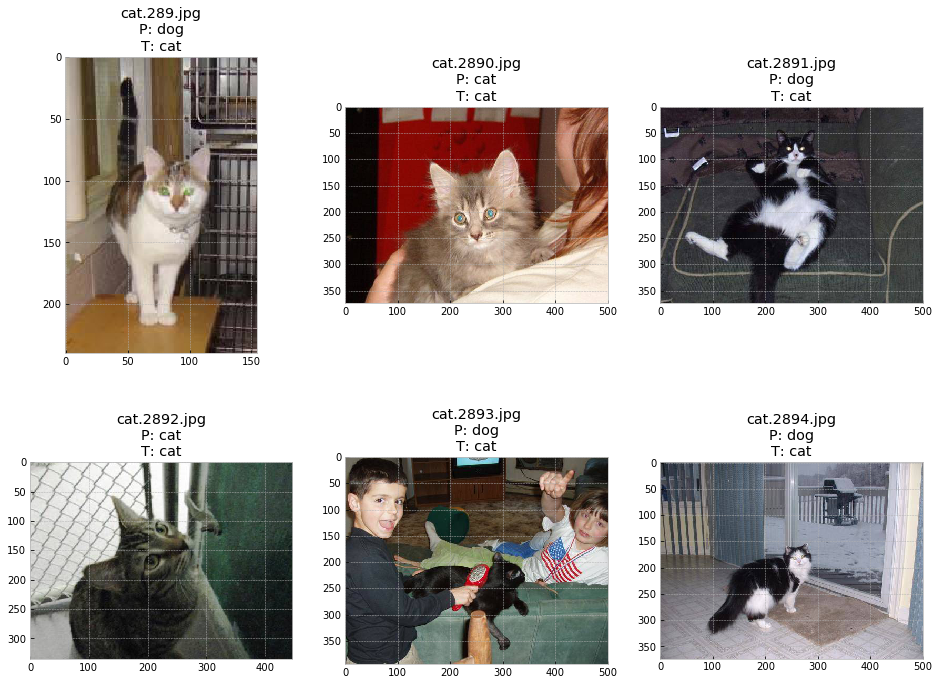

In [22]:
utils.imgs.plot_sample_preds(tst_fpaths, val_probs > 0.5, tst_targs, labels, shuffle=True)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.VAL)
_ = predictions.save_or_append_pred_to_file(pred_fpath, val_probs)

In [ ]:
thresh = TRAIN_CONFIG['threshold']
acc = metric_utils.get_accuracy(val_probs > thresh, val_targs)
f2 = metric_utils.get_metric_in_blocks(val_probs > thresh, val_targs, 
                                       1000, metric_utils.get_f2_score)
loss = metric_utils.get_cross_entropy_loss(val_probs, val_targs)
print("Acc",acc,"F2",f2,"BCE",loss)
utils.imgs.plot_sample_preds(val_fpaths, val_probs > 0.5, val_targs, 
                             dogscats.LABEL_NAMES)

In [ ]:
%time tst_probs = predictions.get_probabilities(model, tst_loader)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.TEST)
_ = predictions.save_or_append_pred_to_file(pred_fpath, tst_probs)
tst_probs = predictions.load_pred(pred_fpath, numpy=True)
utils.imgs.plot_sample_preds(tst_fpaths, tst_probs > thresh, 
                             None, dogscats.LABEL_NAMES)

## Evaluate

In [ ]:
# Review Experiment
exp_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
exp = Experiment(exp_name, cfg.PATHS['experiments'])
exp.review(verbose=False)
exp.history.plot()

In [ ]:
# Load Pred
fname = 'my_exp_val.bc'
thresh = TRAIN_CONFIG['threshold']
probs = predictions.load_pred(os.path.join(cfg.PATHS['predictions'], fname))
preds = predictions.get_predictions(probs, thresh)

In [ ]:
# View preds, probs, and targets
eval_df = evaluate.get_evaluate_df(preds, probs, val_targs, 
                                   val_fpaths, dogscats.LABEL_NAMES)
eval_df[:5]

In [ ]:
# View preds by label
LABEL = 'dog'
dog_preds_by_targ = evaluate.get_preds_by_target_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_pred = evaluate.get_preds_by_predicted_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_targ[:5]

In [ ]:
# View preds by probability

# Confident dogs and right (TP)
confident_dogs_tp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.9, p_max=1.0)
# Confident dogs and wrong (FP)
confident_dogs_fp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.9, p_max=1.0)
# Unconfident dogs and right (TN)
unconfident_dogs_tn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.0, p_max=0.1)
# Unconfident dogs and wrong (FN)
unconfident_dogs_fn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.0, p_max=0.1)

# Annotation errors?
evaluate.plot_predictions(unconfident_dogs_fn, dogscats.LABEL_NAMES)
unconfident_dogs_fn

In [ ]:
# View predictions and probabilities
evaluate.plot_predictions(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Confusion Matrix
evaluate.plot_label_level_cms(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Plot ROC Curve
evaluate.plot_roc_curve(np.array(probs), val_targs)